In [1]:
import os
import numpy as np
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import matplotlib.pyplot as plt
from mne_bids import BIDSPath, read_raw_bids

event_id = {
    'normal': 1,   
    'conflict': 2  
}


In [ ]:
def process_subject(subject_id, session, bids_root):
    
    bids_path = BIDSPath(
        subject=subject_id, session=session, task="PredictionError", suffix="eeg", extension=".vhdr", root=bids_root
    )
    
    # Loads raw data from the bds path
    raw = read_raw_bids(bids_path)

    # Preprocessing
    raw.annotations.onset -= 0.063  # Adjusting the data for EEG setup delay
    raw_resampled = raw.copy().resample(sfreq=250, npad="auto")  # Resampling with desired frequency
    raw_filtered = raw_resampled.filter(l_freq=1.0, h_freq=124.0).notch_filter(freqs=50)  # Bandpass + Notch filter on the signal
    raw_referenced = raw_filtered.set_eeg_reference(ref_channels="average").set_montage("standard_1020")  # Re-referenced the channels
    
    # Extracting events based on annotations
    events = []
    for annot in raw_referenced.annotations:
        print(f"Processing annotation: {annot['description']}")
        if 'normal_or_conflict:normal' in annot['description']:
            events.append([int(annot['onset'] * raw_referenced.info['sfreq']), 0, event_id['normal']])
        elif 'normal_or_conflict:conflict' in annot['description']:
            events.append([int(annot['onset'] * raw_referenced.info['sfreq']), 0, event_id['conflict']])
        else:
            print("Skipping irrelevant annotation:", annot['description'])
    events = np.array(events, dtype=int)

    # Extracting epochs from raw_referenced data
    epochs = mne.Epochs(
        raw_referenced, events, event_id=event_id, tmin=-0.3, tmax=0.7,
        baseline=(-0.3, 0), preload=True, event_repeated='merge'
    )
    print(f"Total epochs: {len(epochs)}")

    # Computing Mean absolute amplitude for every epochs
    epoch_data = epochs.get_data()  
    mean_amplitudes = np.mean(np.abs(epoch_data), axis=(1, 2))  

    ranked_indices = np.argsort(mean_amplitudes)  

    percentage = 85 #considering only 85% of the clean data for further processing
    n_epochs_to_keep = int(len(epochs) * (percentage / 100))
    selected_indices = ranked_indices[:n_epochs_to_keep]  

    clean_epochs = epochs[selected_indices]

    #Applying ICA through python library

    ica = ICA(n_components=10, method='fastica', random_state=42, max_iter=5000)
    ica.fit(clean_epochs)

    ica.plot_components()

    # Using ICLabel for component classification
    labels = label_components(raw_referenced, ica, method='iclabel')

    print("ICLabel Results:")
    for idx, (label, prob) in enumerate(zip(labels['labels'], labels['y_pred_proba'])):
        print(f"Component {idx}: {label} (Probability: {prob:.2f})")

    # Removing artifacts like eye blink, muscle artifacts and line nose
    bad_ics = [idx for idx, label in enumerate(labels['labels'])
            if label in ('eye blink', 'muscle artifact', 'line_noise')]

    ica.exclude = bad_ics  

    ica.apply(raw_referenced)

    raw_referenced.set_meas_date(None)

    #Filtering ERP data with 0.2 Hz high-pass and 35 Hz low-pass
    raw_referenced = raw_referenced.copy().filter(l_freq=0.2, h_freq=35.0)

    # Rejecting 10% of the noisiest epochs based on amplitude of the signal
    epoch_data = epochs.get_data()  
    mean_amplitudes = np.mean(np.abs(epoch_data), axis=(1, 2))  
    threshold = np.percentile(mean_amplitudes, 90) 
    clean_epochs = epochs[mean_amplitudes < threshold]

    # Focusing on analysing selected electrodes 
    frontal_channels = ['Fz', 'Cz', 'Fp1', 'FC1', 'FC2']
    clean_epochs.pick_channels(frontal_channels)

    # Extract ERP negativity peaks in the specific time window
    time_window = (0.1, 0.3)  #100-300 ms 
    negativity_peaks = {}

    for ch_name in frontal_channels:
        channel_idx = clean_epochs.ch_names.index(ch_name)
        erp_data = clean_epochs.average().data[channel_idx]
        times = clean_epochs.times

        mask = (times >= time_window[0]) & (times <= time_window[1])
        time_window_data = erp_data[mask]
        time_window_times = times[mask]

        peak_idx = np.argmin(time_window_data)
        peak_time = time_window_times[peak_idx]
        peak_amplitude = time_window_data[peak_idx]

        negativity_peaks[ch_name] = (peak_time, peak_amplitude)
        print(f"Channel {ch_name}: Negativity peak at {peak_time:.3f} s with amplitude {peak_amplitude:.3f} µV")


    epochs_match = epochs['normal']
    epochs_mismatch = epochs['conflict']
    print(f"Match trials: {len(epochs_match)}, Mismatch trials: {len(epochs_mismatch)}")


    erp_normal = epochs_match.average()
    erp_conflict = epochs_mismatch.average()

    return erp_normal.data, erp_conflict.data, raw_referenced

Extracting parameters from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_events.tsv.
Reading channel info from /home/st/st_us-053000/st_st190561/EEG/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_channels.tsv.


/scratch/ipykernel_620400/3364865234.py:8: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Processing annotation: block:start;currentBlockNr:1;condition:vibro;training:false
Skipping irrelevant annotation: block:start;currentBlockNr:1;condition:vibro;training:false
Processing annotation: box:spawned;condition:vibro;trial_nr:1;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.724326
Processing annotation: box:touched;condition:vibro;vibroFeedback:on;reaction_time:0.9386394;trial_nr:1;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.724326;vibro_duration:0.1
Processing annotation: box:touched;condition:vibro;emsFeedback:on;reaction_time:0.9386394;trial_nr:1;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.724326;emsCurrent:7;emsWidth:200;pulseCount:12
Processing annotation: vibroFeedback:off;vibroFeedbackDuration:0.1117282
Skipping irrelevant annotation: vibroFeedback:off;vibroFeedbackDuration:0.1117282
Processing annotation: visualFeedback:off
Skipping irrelevant annotation: visualFeedback:off
Proces

/scratch/ipykernel_620400/3364865234.py:14: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_referenced = raw_filtered.set_eeg_reference(ref_channels="average").set_montage("standard_1020")  # Re-referenced the channels


0 bad epochs dropped
Total epochs: 300
Fitting ICA to data using 63 channels (please be patient, this may take a while)


/scratch/ipykernel_620400/3364865234.py:50: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(clean_epochs)


Selecting by number: 10 components
Fitting ICA took 10.2s.


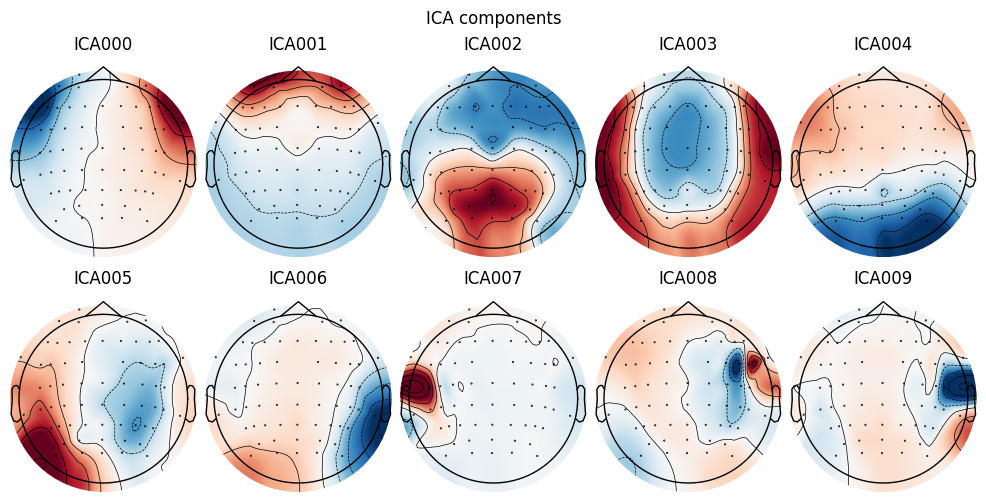

/scratch/ipykernel_620400/3364865234.py:55: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw_referenced, ica, method='iclabel')
/scratch/ipykernel_620400/3364865234.py:55: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  labels = label_components(raw_referenced, ica, method='iclabel')


ICLabel Results:
Component 0: eye blink (Probability: 1.00)
Component 1: eye blink (Probability: 1.00)
Component 2: brain (Probability: 1.00)
Component 3: brain (Probability: 1.00)
Component 4: brain (Probability: 0.97)
Component 5: brain (Probability: 0.99)
Component 6: brain (Probability: 0.71)
Component 7: muscle artifact (Probability: 0.85)
Component 8: brain (Probability: 0.94)
Component 9: brain (Probability: 0.73)
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 3 ICA components
    Projecting back using 63 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Uppe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Channel Fz: Negativity peak at 0.128 s with amplitude -0.000 µV
Channel Cz: Negativity peak at 0.160 s with amplitude -0.000 µV
Channel Fp1: Negativity peak at 0.184 s with amplitude -0.000 µV
Channel FC1: Negativity peak at 0.180 s with amplitude -0.000 µV
Channel FC2: Negativity peak at 0.104 s with amplitude -0.000 µV
Match trials: 225, Mismatch trials: 75
Shape of normal_data for subject 02, session EMS: (63, 251)
Shape of conflict_data for subject 02, session EMS: (63, 251)
The channels are: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO

/scratch/ipykernel_620400/3364865234.py:8: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


In [ ]:
bids_root = "/home/st/st_us-053000/st_st190561/EEG" # path to the bids_root folder
subjects = ["02", "03", "06", "07", "08", "11", "12", "13", "14", "15", "16"] # Hard-coded valid subjects for experiment
sessions = ["EMS", "Vibro", "Visual"]

all_normal_ems = []
all_conflict_ems = []
all_normal_vibro = []
all_conflict_vibro = []
all_normal_visual = []
all_conflict_visual = []

for subject in subjects:
    for session in sessions:
        try:
            normal_data, conflict_data, raw_referenced = process_subject(subject, session, bids_root)
            print(f"Shape of normal_data for subject {subject}, session {session}: {normal_data.shape}")
            print(f"Shape of conflict_data for subject {subject}, session {session}: {conflict_data.shape}")
            print("The channels are:",raw_referenced.ch_names)

            if session == "EMS":
                all_normal_ems.append(normal_data)
                all_conflict_ems.append(conflict_data)
            elif session == "Vibro":
                all_normal_vibro.append(normal_data)
                all_conflict_vibro.append(conflict_data)
            elif session == "Visual":
                all_normal_visual.append(normal_data)
                all_conflict_visual.append(conflict_data)

        except FileNotFoundError:
            print(f"File not found for subject {subject}, session {session}. Skipping this session.")
            continue

avg_normal_ems = np.mean(all_normal_ems, axis=0)
avg_conflict_ems = np.mean(all_conflict_ems, axis=0)
avg_normal_vibro = np.mean(all_normal_vibro, axis=0)
avg_conflict_vibro = np.mean(all_conflict_vibro, axis=0)
avg_normal_visual = np.mean(all_normal_visual, axis=0)
avg_conflict_visual = np.mean(all_conflict_visual, axis=0)

channel = 'Fz'

raw_example = read_raw_bids(BIDSPath(
    subject=subjects[0], session=sessions[0], task="PredictionError", suffix="eeg", extension=".vhdr", root=bids_root
))
channel_idx = raw_referenced.info['ch_names'].index(channel)

erp_normal_ems = avg_normal_ems[channel_idx, :] 
erp_conflict_ems = avg_conflict_ems[channel_idx, :]  
erp_normal_vibro = avg_normal_vibro[channel_idx, :]  
erp_conflict_vibro = avg_conflict_vibro[channel_idx, :]
erp_normal_visual = avg_normal_visual[channel_idx, :]  
erp_conflict_visual = avg_conflict_visual[channel_idx, :]  

erp_difference_ems = erp_conflict_ems - erp_normal_ems
erp_difference_vibro = erp_conflict_vibro - erp_normal_vibro
erp_difference_visual = erp_conflict_visual - erp_normal_visual

times = np.linspace(-0.3, 0.7, erp_normal_ems.shape[0])  


fig, axs = plt.subplots(3, 1, figsize=(12, 36), sharex=True)

axs[0].plot(times, erp_normal_ems * 1e6, label=f'EMS', color='red')
axs[0].plot(times, erp_normal_vibro * 1e6, label=f'Vibro', color='yellow')
axs[0].plot(times, erp_normal_visual * 1e6, label=f'Visual', color='blue')
axs[0].axvspan(0.1, 0.3, color='gray', alpha=0.2, label='Peak Search Window')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_title("ERP Match Across Sessions")
axs[0].set_ylabel("Amplitude (µV)")
axs[0].legend()

axs[1].plot(times, erp_conflict_ems * 1e6, label=f'EMS', color='red')
axs[1].plot(times, erp_conflict_vibro * 1e6, label=f'Vibro', color='yellow')
axs[1].plot(times, erp_conflict_visual * 1e6, label=f'Visual', color='blue')
axs[1].axvspan(0.1, 0.3, color='gray', alpha=0.2, label='Peak Search Window')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_title("ERP Mismatch Across Sessions")
axs[1].set_ylabel("Amplitude (µV)")
axs[1].legend()

axs[2].plot(times, erp_difference_ems * 1e6, label=f'EMS', color='red')
axs[2].plot(times, erp_difference_vibro * 1e6, label=f'Vibro', color='yellow')
axs[2].plot(times, erp_difference_visual * 1e6, label=f'Visual', color='blue')
axs[2].axvspan(0.1, 0.3, color='gray', alpha=0.2, label='Peak Search Window')
axs[2].axhline(0, color='black', linestyle='--')
axs[2].set_title("ERP Difference (Mismatch - Match) Across Sessions")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Amplitude (µV)")
axs[2].legend()

plt.tight_layout()
plt.savefig("/home/st/st_us-053000/st_st190561/EEG/fz.png")
plt.show()